In [1]:
import os
import csv
import numpy as np
import matplotlib.pyplot as plt
import math
from tqdm import trange
import allan_variance
import pandas as pd
from calibration import IntrinsicCalibration
from scipy.spatial.transform import Rotation as R
from scipy.linalg import null_space


/home/su/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def read_txt(datafile):
    with open(datafile, "r") as file:
        lines = file.readlines()
        data = [[float(num) for num in line.split()] for line in lines]
    return data

def csv_write(data, filename):
    filepath = os.getcwd()
    with open(os.path.join(filepath, filename), 'w') as f:
        wh = csv.writer(f, delimiter =' ', quoting=csv.QUOTE_NONE)
        for datum in data:
            wh.writerow(['{:.6f}'.format(x) for x in datum])

In [3]:
def left_nullspace_projection(A):
    A_transpose = A.T
    nullspace_basis = null_space(A_transpose)
    projection_matrix = nullspace_basis @ nullspace_basis.T
    return projection_matrix

def compute_virtual_imu(meas, rotations, positions, num_imu):
    """
    Compute virtual IMU measurements (gyroscope and accelerometer) from two IMUs.
    
    Parameters:
        omega_A, omega_B: Angular velocities from IMU A and B
        a_A, a_B: Accelerations from IMU A and B
        ARV, BRV: Rotation matrices from virtual frame V to IMU frames A and B
        VpA, VpB: Positions of IMU A and B in the virtual IMU frame
        sigma_g: Gyroscope noise standard deviation
    
    Returns:
        omega_V: Virtual gyroscope measurement
        a_V: Virtual accelerometer measurement
    """
    # Define matrices as per the equations in the paper
    N = np.vstack(rotations)
    Y = []
    omeag_m = []
    a_m = []
    S_omega_V = []
    for i in range(num_imu):
        Y.append(rotations[i] @ skew_matrix(positions[i]))
        omeag_m.append(meas[i*6+3:i*6+6])
        a_m.append(meas[i*6:i*6+3])
    omega_m = np.hstack(omeag_m)
    a_m = np.hstack(a_m)
    Y = np.vstack(Y)
    ZT = left_nullspace_projection(Y)
    omega_V = np.linalg.pinv(N) @ omega_m

    for i in range(num_imu):
        S_omega_V.append(rotations[i] @ np.dot(skew_matrix(omega_V), skew_matrix(omega_V)) @ positions[i])
    S_omega_V = np.hstack(S_omega_V)
    T = np.linalg.pinv(ZT @ N) @ ZT
    a_V = T @ (a_m - S_omega_V)
    
    return omega_V, a_V

def skew_matrix(v):
    return np.array([[0, -v[2], v[1]],
                     [v[2], 0, -v[0]],
                     [-v[1], v[0], 0]])



Simulated Dataset

In [6]:
# measurements
measurements = np.array(read_txt("../data/imu18.txt"))


In [7]:
num_imus = 18
Rb_si = [np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), 
         np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3), np.eye(3)] # Rotation matrix
pos_r = -np.array([[0.0, 0.0, 0.1],
         [0.0, 0.1, 0.0],
         [0.0, 0.0, 0.0], 
         [0.1, 0.0, 0.0],
         [0.0, 0.2, 0.0],
         [0.0, 0.0, 0.2],
         [0.2, 0.0, 0.0],
         [0.0, 0.3, 0.0],
         [0.0, 0.0, 0.3],
         [0.3, 0.0, 0.0],
         [0.0, 0.0, 0.4],
         [0.0, 0.4, 0.0],
         [0.4, 0.0, 0.0],
         [0.0, 0.0, 0.5],
         [0.0, 0.5, 0.0],
         [0.5, 0.0, 0.0],
         [0.0, 0.0, 0.6],
         [0.0, 0.6, 0.0]])
dt = 1e-2
time = np.arange(0, 360, dt)
omega_V_hist = np.zeros((len(time), 3))
a_V_hist = np.zeros((len(time), 3))

for i in trange(len(time)):
    omega_V, a_V = compute_virtual_imu(measurements[i,:num_imus*6], Rb_si[:num_imus], pos_r[:num_imus], num_imus)
    omega_V_hist[i] = omega_V
    a_V_hist[i] = a_V

# csv_write(state_est_hist, filename)

  0%|          | 0/36000 [00:00<?, ?it/s]

100%|██████████| 36000/36000 [00:24<00:00, 1470.53it/s]


Text(0.5, 0, 'Time (s)')

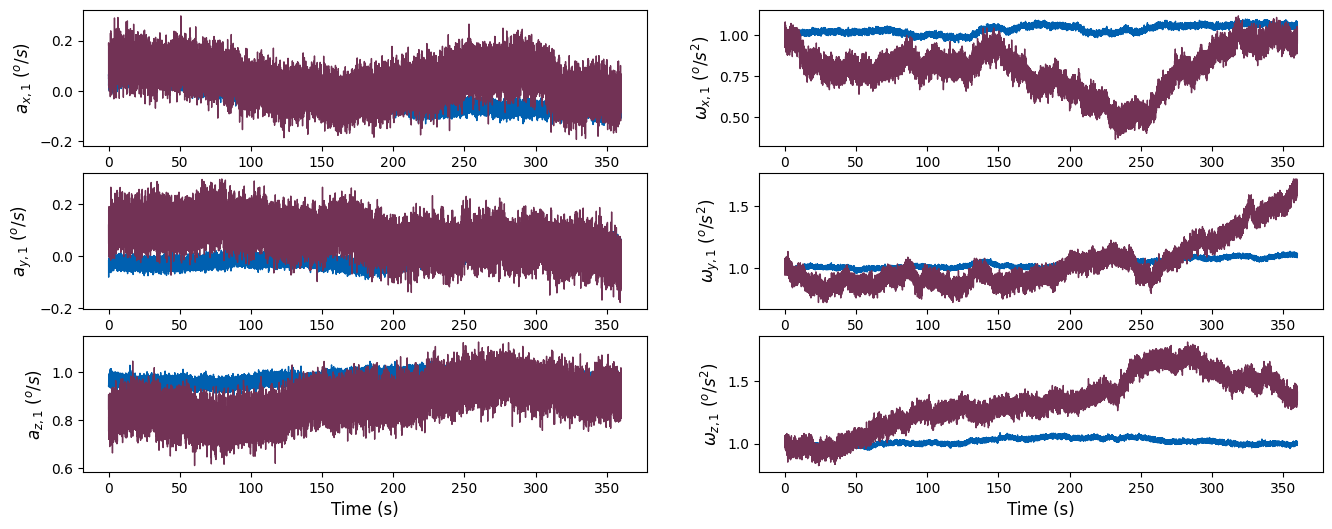

In [8]:
fig2, ax2 = plt.subplots(3, 2, figsize = (16, 6))
ax2[0,0].plot(time,     a_V_hist[:,0], linewidth=1, color = "#0060B0")
ax2[0,0].plot(time, measurements[:,0], linewidth=1, color = "#723255")
ax2[1,0].plot(time,     a_V_hist[:,1], linewidth=1, color = "#0060B0")
ax2[1,0].plot(time, measurements[:,1], linewidth=1, color = "#723255")
ax2[2,0].plot(time,     a_V_hist[:,2], linewidth=1, color = "#0060B0")
ax2[2,0].plot(time, measurements[:,2], linewidth=1, color = "#723255")
ax2[0,0].set_ylabel("$a_{x,1}$ ($^{o}/s$)", fontsize=12)
ax2[1,0].set_ylabel("$a_{y,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_ylabel("$a_{z,1}$ ($^{o}/s$)", fontsize=12)
ax2[2,0].set_xlabel("Time (s)", fontsize=12)

ax2[0,1].plot(time, omega_V_hist[:,0], linewidth=1, color = "#0060B0")
ax2[0,1].plot(time, measurements[:,3], linewidth=1, color = "#723255")
ax2[1,1].plot(time, omega_V_hist[:,1], linewidth=1, color = "#0060B0")
ax2[1,1].plot(time, measurements[:,4], linewidth=1, color = "#723255")
ax2[2,1].plot(time, omega_V_hist[:,2], linewidth=1, color = "#0060B0")
ax2[2,1].plot(time, measurements[:,5], linewidth=1, color = "#723255")
ax2[0,1].set_ylabel("$\omega_{x,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[1,1].set_ylabel("$\omega_{y,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_ylabel("$\omega_{z,1}$ ($^{o}/s^2$)", fontsize=12)
ax2[2,1].set_xlabel("Time (s)", fontsize=12)

In [9]:
axis = ['x', 'y', 'z']

dt = 0.01
    
for i in range(3):
    tau_w, avar_w = allan_variance.compute_avar(omega_V_hist[:,i], dt)
    tau_a, avar_a = allan_variance.compute_avar(a_V_hist[:,i], dt)
    params_w, _ = allan_variance.estimate_parameters(tau_w, avar_w)
    params_a, _ = allan_variance.estimate_parameters(tau_a, avar_a)
    print(f"{params_w['white']:0.6f}")
    print(f"{params_w['walk']:0.6f}")
    print(f"{params_a['white']:0.6f}")
    print(f"{params_a['walk']:0.6f}")

0.000769
0.004496
0.001378
0.002826
0.000758
0.004311
0.001313
0.002277
0.000684
0.003720
0.001228
0.002262


DISIMU SF hat: quantization    0.00001109136514
white           0.00076862542200
flicker         0.00000000000000
walk            0.00449599263854
ramp            0.00029181417718
Name: 0, dtype: float64, quantization    0.00001494424998
white           0.00075773492055
flicker         0.00066023536565
walk            0.00431070174395
ramp            0.00000000000000
Name: 0, dtype: float64, quantization    0.00002524571509
white           0.00068448192229
flicker         0.00180054851806
walk            0.00371978092161
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

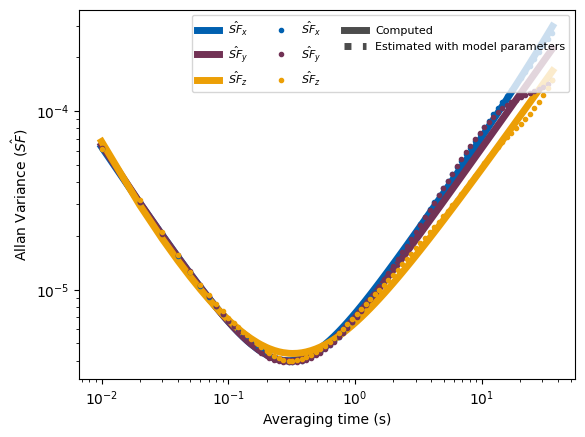

In [10]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(omega_V_hist[:,0], dt)
tau_fy, avar_fy = allan_variance.compute_avar(omega_V_hist[:,1], dt)
tau_fz, avar_fz = allan_variance.compute_avar(omega_V_hist[:,2], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU SF hat: {params_fx}, {params_fy}, {params_fz}")


# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")

DISIMU SF hat: quantization    0.00002592468767
white           0.00137761613537
flicker         0.00083647109472
walk            0.00282587648018
ramp            0.00036404648223
Name: 0, dtype: float64, quantization    0.00001850947075
white           0.00131319448461
flicker         0.00126155887692
walk            0.00227720703612
ramp            0.00038728413637
Name: 0, dtype: float64, quantization    0.00003817469257
white           0.00122776616118
flicker         0.00171435540689
walk            0.00226213743368
ramp            0.00000000000000
Name: 0, dtype: float64


Text(0, 0.5, 'Allan Variance ($\\hat{SF}$)')

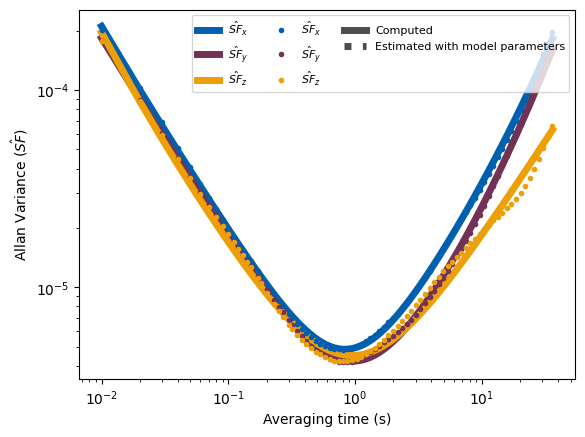

In [11]:
# DISIMU, SF hat
tau_fx, avar_fx = allan_variance.compute_avar(a_V_hist[:,0], dt)
tau_fy, avar_fy = allan_variance.compute_avar(a_V_hist[:,1], dt)
tau_fz, avar_fz = allan_variance.compute_avar(a_V_hist[:,2], dt)
params_fx, avar_pred_fx = allan_variance.estimate_parameters(tau_fx, avar_fx)
params_fy, avar_pred_fy = allan_variance.estimate_parameters(tau_fy, avar_fy)
params_fz, avar_pred_fz = allan_variance.estimate_parameters(tau_fz, avar_fz)
print(f"DISIMU SF hat: {params_fx}, {params_fy}, {params_fz}")


# Computed
fig, ax = plt.subplots()
plt.loglog(tau_fx, avar_pred_fx, label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_pred_fy, label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_pred_fz, label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# Estimated
plt.loglog(tau_fx, avar_fx, '.', label="$\hat{SF}_x$", linewidth=5, color = "#0060B0")
plt.loglog(tau_fy, avar_fy, '.', label="$\hat{SF}_y$", linewidth=5, color = "#723255")
plt.loglog(tau_fz, avar_fz, '.', label="$\hat{SF}_z$", linewidth=5, color = "#EC9F06")
# ax.set_ylim([0.00000001, 0.01])

line1, = plt.plot([], [], color='k', linestyle="-", alpha=0.7, linewidth=5, label='Computed')
line2, = plt.plot([], [], color='k', linestyle="dotted", alpha=0.7, linewidth=5, label='Estimated with model parameters')

plt.legend(ncol=3, fancybox=True, frameon=True, fontsize=8, loc='upper right')
plt.xlabel("Averaging time (s)")
plt.ylabel("Allan Variance ($\hat{SF}$)")